# Neural Machine Translation

##  Requirements:
* Python 2.7
* PyTorch
* NumPy
* NLTK
* Data: download [German-English](http://www.manythings.org/anki/deueng.zip) and extract as deu.txt

In [1]:
from io import open
from unicodedata import normalize
import string
import re
import random
import os

import numpy as np
import nltk

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES']='0'

file_name   = './deu.txt'
token_PAD   = 0
token_BEGIN = 1
token_END   = 2
MIN_WORD_COUNT   = 10
MIN_SENTENCE_LENGTH = 3
MAX_SENTENCE_LENGTH = 30

### Define functions to read sentence pairs from deu.txt 
* deu.txt is downloaded and unzipped to current directory

In [2]:
#####################################################################################
# clean sentence string read from deu.txt
#####################################################################################
def clean_string(sentence):    
    sentence = normalize('NFD', sentence).encode('ascii', 'ignore').decode('UTF-8')
    sentence = sentence.lower().strip() 
    sentence = re.sub(r'[^\w\s]', r' ', sentence)
    return ' '.join(sentence.split())

#####################################################################################
# read sentence pairs from deu.txt and remove too long / too short sentence pairs
#####################################################################################
def read_string(file_name):
    lines = open(file_name, encoding='utf-8').read().strip().split('\n')
    pairs = [[clean_string(s) for s in l.split('\t')] for l in lines]
    pairs = [list(reversed(p)) for p in pairs]

    pairs_new = []
    for pair in pairs:
        if min([len(pair[0]), len(pair[1])]) > MIN_SENTENCE_LENGTH and \
           max([len(pair[0]), len(pair[1])]) < MAX_SENTENCE_LENGTH:
                pairs_new.append(pair)
    return np.array(pairs_new), len(pairs), len(pairs_new)

#####################################################################################
# tokenize German and English vocabulary
#####################################################################################
class tokenizer:
    def __init__(self, name):
        self.name = name
        self.index_dict = {token_BEGIN: "TBEGIN", token_END: "TEND", token_PAD: "TPAD"}
        self.word_dict = {}
        self.word_count = {}
        self.word_num = 3 
        self.trimmed = False

    def read_sentences(self, sentences):
        for sentence in sentences:
            for word in sentence.split(' '):
                self.read_word(word)

    def read_word(self, word):
        if word not in self.word_dict:
            self.index_dict[self.word_num] = word
            self.word_dict[word] = self.word_num
            self.word_count[word] = 1            
            self.word_num += 1
        else:
            self.word_count[word] += 1      
    
    def trim_word(self, min_count):
        if self.trimmed: return
        self.trimmed = True        
        keep_words = []
        
        for k, v in self.word_count.items():
            if v >= min_count:
                keep_words.append(k)
        
        self.index_dict = {token_BEGIN: "TBEGIN", token_END: "TEND", token_PAD: "TPAD"}
        self.word_dict = {}        
        self.word_count = {}
        self.word_num = 3 

        for word in keep_words:
            self.read_word(word)

#####################################################################################
# remove sentence pairs with rare words
#####################################################################################
def clean_pairs(pairs, input_lang, output_lang):
    keep_pairs = np.zeros(pairs.shape[0])
    for i in range(pairs.shape[0]):
        input_sentence = pairs[i,0]
        output_sentence = pairs[i,1]
        keep_input = True
        keep_output = True
        for word in input_sentence.split(' '):
            if word not in input_lang.word_dict:
                keep_input = False
                break
        for word in output_sentence.split(' '):
            if word not in output_lang.word_dict:
                keep_output = False
                break
        if keep_input and keep_output:
            keep_pairs[i] = 1
    return np.squeeze(pairs[np.argwhere(keep_pairs == 1), :])

### Display number of pairs processed, and split into train vs. validation vs. test
* sentences too long / too short / have rare words are removed

In [3]:
pairs, size_ori, size_new = read_string(file_name)
print('Read and select sentences with: {} < sentence length < {}'.format(MIN_SENTENCE_LENGTH, MAX_SENTENCE_LENGTH))
print('Original number of total pairs = {}'.format(size_ori))
print('Selected number of total pairs = {}'.format(size_new))

input_lang = tokenizer('German')
input_lang.read_sentences(pairs[:, 0])
output_lang = tokenizer('English')
output_lang.read_sentences(pairs[:, 1])
print('------------------------------------')
print('{}: original vocabulary size = {}'.format(input_lang.name, input_lang.word_num))
print('{}: original vocabulary size = {}'.format(output_lang.name, output_lang.word_num))

input_lang.trim_word(MIN_WORD_COUNT)
output_lang.trim_word(MIN_WORD_COUNT)
print('------------------------------------')
print('Remove sentences with rare words (count < {})'.format(MIN_WORD_COUNT))
print('{}: trimmed vocabulary size = {}'.format(input_lang.name, input_lang.word_num))
print('{}: trimmed vocabulary size = {}'.format(output_lang.name, output_lang.word_num))

pairs = clean_pairs(pairs, input_lang, output_lang)
np.random.seed(0)
randord = np.random.permutation(range(pairs.shape[0])).tolist()
pairs_train = pairs[randord[:int(pairs.shape[0]*0.6)],:]
pairs_val = pairs[randord[int(pairs.shape[0]*0.6):int(pairs.shape[0]*0.8)],:]
pairs_test = pairs[randord[int(pairs.shape[0]*0.8):],:]

print('------------------------------------')
print('Trimmed Number of total pairs = {}'.format(pairs.shape[0]))
print('Number of training pairs = {}'.format(pairs_train.shape[0]))
print('Number of validation pairs = {}'.format(pairs_val.shape[0]))
print('Number of test pairs = {}'.format(pairs_test.shape[0]))

Read and select sentences with: 3 < sentence length < 30
Original number of total pairs = 159204
Selected number of total pairs = 52711
------------------------------------
German: original vocabulary size = 11405
English: original vocabulary size = 7207
------------------------------------
Remove sentences with rare words (count < 10)
German: trimmed vocabulary size = 1889
English: trimmed vocabulary size = 1651
------------------------------------
Trimmed Number of total pairs = 30679
Number of training pairs = 18407
Number of validation pairs = 6136
Number of test pairs = 6136


### Define functions to pad sentences for training mini batch

In [4]:
#####################################################################################
# convert sentence words into a list of indexes
#####################################################################################
def sentence_index(lang, sentence):
    return [lang.word_dict[word] for word in sentence.split(' ')] + [token_END]

#####################################################################################
# pad sentence for mini batch training
#####################################################################################
def sentence_padding(sentence, max_length):
    sentence += [token_PAD for i in range(max_length - len(sentence))]
    return sentence

#####################################################################################
# generate random batch for training
#####################################################################################
def batch_generator(pairs, batch_size):
    input_seqs = []
    output_seqs = []
    for i in range(batch_size):
        pair = random.choice(pairs)
        input_seqs.append(sentence_index(input_lang, pair[0]))
        output_seqs.append(sentence_index(output_lang, pair[1]))
    
    seq_pairs = sorted(zip(input_seqs, output_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, output_seqs = zip(*seq_pairs)
    
    input_lengths = [len(s) for s in input_seqs]
    output_lengths = [len(s) for s in output_seqs]
    input_seqs = [sentence_padding(s, max(input_lengths)) for s in input_seqs]
    output_seqs = [sentence_padding(s, max(output_lengths)) for s in output_seqs]

    input_batch = Variable(torch.LongTensor(input_seqs)).transpose(0, 1).cuda()
    output_batch = Variable(torch.LongTensor(output_seqs)).transpose(0, 1).cuda()
        
    return input_batch, input_lengths, output_batch, output_lengths

#####################################################################################
# identify sentence before padding
#####################################################################################
def sentence_mask(sentence_length, max_len=None):
    if max_len is None:
        max_len = sentence_length.data.max()
    batch_size = sentence_length.size(0)
    seq_range = torch.range(0, max_len - 1).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    if sentence_length.is_cuda:
        seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sentence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand

#####################################################################################
# compute cross_entropy loss on unpadded sentence
#####################################################################################
def sentence_cross_entropy(logits, target, length):
    length = Variable(torch.LongTensor(length)).cuda()
    logits_flat = logits.view(-1, logits.size(-1))
    log_probs_flat = F.log_softmax(logits_flat, dim=1)
    target_flat = target.view(-1, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    losses = losses_flat.view(*target.size())
    mask = sentence_mask(sentence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss

### Define encoder

In [5]:
#####################################################################################
# define encoder: 
# word embedding -> lstm
#####################################################################################
# encoder model
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0.1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional=True)
        
    def forward(self, input_batch, input_lengths):
        embedded = self.embedding(input_batch)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.lstm(packed)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) 
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] 
        return outputs, hidden

### Define decoder with attention

In [6]:
#####################################################################################
# define decoder: 
# ((word embedding -> lstm) + encoder output)-> attention -> concat -> relu -> fc
#####################################################################################
# attention model
class Attention(nn.Module):
    def __init__(self, method_name, hidden_size):
        super(Attention, self).__init__()        
        self.method_name = method_name
        self.hidden_size = hidden_size
        self.attention = nn.Linear(self.hidden_size, hidden_size)
        self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_length = encoder_outputs.size(0)
        batch_size = encoder_outputs.size(1)

        attention_energy = Variable(torch.zeros(batch_size, max_length)).cuda()
        for nb in range(batch_size):
            for nl in range(max_length):
                attention_energy[nb, nl] = self.score(hidden[:, nb], encoder_outputs[nl, nb].unsqueeze(0))
        return F.softmax(attention_energy).unsqueeze(1)
    
    def score(self, hidden, encoder_output):      
        if self.method_name == 'general':            
            energy = hidden.dot(self.attention(encoder_output))    
        elif self.method_name == 'concat':
            self.attention = nn.Linear(self.hidden_size * 2, hidden_size)
            energy = self.v.dot(self.attention(torch.cat((hidden, encoder_output), 1)))
        else:
            energy = hidden.dot(encoder_output) 
        return energy

# decoder model
class Decoder(nn.Module):
    def __init__(self, attention_method, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(Decoder, self).__init__()

        self.attention_method = attention_method
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.attention = Attention(attention_method, hidden_size)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, input_batch, last_hidden, encoder_outputs):

        batch_size = input_batch.size(0)
        embedded = self.embedding(input_batch).view(1, batch_size, self.hidden_size) 
        
        rnn_output, hidden = self.lstm(embedded, last_hidden)

        attention_weights = self.attention(rnn_output, encoder_outputs)
        context = attention_weights.bmm(encoder_outputs.transpose(0, 1)) 

        rnn_output = rnn_output.squeeze(0) 
        context = context.squeeze(1)       
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = self.relu(self.fc1(concat_input))

        output = self.fc2(concat_output)
        return output, hidden, attention_weights

### Define training function

In [7]:
#####################################################################################
# define training: use teacher forcing for training
#####################################################################################
def train(input_batch, input_lengths, output_batch, output_lengths, 
          encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    
    loss = 0 
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    encoder_outputs, encoder_hidden = encoder(input_batch, input_lengths)
    decoder_input = Variable(torch.LongTensor([token_BEGIN] * batch_size)).cuda()
    decoder_hidden = (encoder_hidden[0][:decoder.n_layers], encoder_hidden[1][:decoder.n_layers])

    max_output_length = max(output_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_output_length, batch_size, decoder.output_size)).cuda()

    for t in range(max_output_length):
        decoder_output, decoder_hidden, decoder_Attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        all_decoder_outputs[t] = decoder_output
        decoder_input = output_batch[t] 

    loss = sentence_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(), 
        output_batch.transpose(0, 1).contiguous(), 
        output_lengths
    )
    loss.backward()    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0]

### Define evaluatioin function

In [8]:
#####################################################################################
# define evaluation function: record loss and bleu score
#####################################################################################
def evaluate(input_lang, output_lang, pairs, encoder, decoder, max_length = MAX_SENTENCE_LENGTH):
    
    output_sentences = []
    bleu_scores = []
    losses = []
    for pair in pairs:

        input_batch = [sentence_index(input_lang, pair[0])]
        input_lengths = [len(s) for s in input_batch]
        input_batch = Variable(torch.LongTensor(input_batch), volatile=True).transpose(0, 1).cuda()

        output_batch = [sentence_index(output_lang, pair[1])]
        output_lengths = [len(s) for s in output_batch]    
        output_batch = [sentence_padding(s, max_length) for s in output_batch]
        output_batch = Variable(torch.LongTensor(output_batch), volatile=True).transpose(0, 1).cuda()

        encoder.train(False)
        decoder.train(False)

        encoder_outputs, encoder_hidden = encoder(input_batch, input_lengths)
        decoder_input = Variable(torch.LongTensor([token_BEGIN]), volatile=True).cuda()
        decoder_hidden = (encoder_hidden[0][:decoder.n_layers], encoder_hidden[1][:decoder.n_layers])

        decoded_words = []
        decoder_attentions = torch.zeros(max_length + 1, max_length + 1)
        all_decoder_outputs = Variable(torch.zeros(max_length, 1, decoder.output_size)).cuda()

        for n_curr in range(max_length):
            decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
            all_decoder_outputs[n_curr] = decoder_output

            _, top_index = decoder_output.data.topk(1)
            index_curr = top_index[0][0]
            if index_curr == token_END:
                decoded_words.append('TEND')
                break
            else:
                decoded_words.append(output_lang.index_dict[index_curr])

            decoder_input = Variable(torch.LongTensor([index_curr])).cuda()

        loss = sentence_cross_entropy(all_decoder_outputs.transpose(0, 1).contiguous(),
                                    output_batch.transpose(0, 1).contiguous(), output_lengths)

        encoder.train(True)
        decoder.train(True)
        
        output_sentence = ' '.join(decoded_words[:-1])
        output_sentences.append(output_sentence)
        reference = [pair[1].split(' ')]
        hypothesis = output_sentence.split(' ')
        bleu_scores.append(nltk.translate.bleu_score.sentence_bleu(reference,hypothesis))    
        losses.append(loss.data[0])
    
    return output_sentences, losses, bleu_scores

### Define hyperparameters and initialize model
* print summary of encoder and decoder

In [9]:
attention_method = 'general'
hidden_size = 256
n_layers = 2
dropout = 0.1
batch_size = 300

encoder_learning_rate = 0.001
decoder_learning_rate = 0.005
n_epochs = 100
iter_epoch = 10 
iter_max   = n_epochs * iter_epoch

# initialize models
encoder = Encoder(input_lang.word_num, hidden_size, n_layers, dropout=dropout).cuda()
decoder = Decoder(attention_method, hidden_size, output_lang.word_num, n_layers, dropout=dropout).cuda()

# initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=encoder_learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=decoder_learning_rate)
criterion = nn.CrossEntropyLoss()

print(encoder)
print(decoder)

Encoder(
  (embedding): Embedding(1889, 256)
  (lstm): LSTM(256, 256, num_layers=2, dropout=0.1, bidirectional=True)
)
Decoder(
  (embedding): Embedding(1651, 256)
  (lstm): LSTM(256, 256, num_layers=2, dropout=0.1)
  (attention): Attention(
    (attention): Linear(in_features=256, out_features=256, bias=True)
  )
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (relu): ReLU(inplace)
  (fc2): Linear(in_features=256, out_features=1651, bias=True)
)


### Begin training

In [10]:
#####################################################################################
# training process:
# save best models of encoder and decoder, based on validation loss
#####################################################################################
LOSS_train = []
BLEU_train = []
LOSS_val = []
BLEU_val = []

niter = 0
history_loss_best = 10**6
history_tolerance = 0
best_epoch = 0

while niter < iter_max:    
    input_batch, input_lengths, output_batch, output_lengths = batch_generator(pairs_train, batch_size)
    loss_curr = train(input_batch, input_lengths, output_batch, output_lengths,
                       encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    
    if niter % iter_epoch == 0:
        _, loss_train, bleu_train = evaluate(
            input_lang, output_lang, pairs_train, encoder, decoder, MAX_SENTENCE_LENGTH) 
        _, loss_val, bleu_val = evaluate(
            input_lang, output_lang, pairs_val, encoder, decoder, MAX_SENTENCE_LENGTH)      
        
        LOSS_train.append(sum(loss_train)/len(loss_train))
        BLEU_train.append(sum(bleu_train)/len(bleu_train))
        LOSS_val.append(sum(loss_val)/len(loss_val))
        BLEU_val.append(sum(bleu_val)/len(bleu_val))
        
        nepoch = niter/iter_epoch
        
        if nepoch > 20 and LOSS_val[nepoch] < history_loss_best and history_tolerance <= 10:
            torch.save(encoder.state_dict(), './model_encoder.pt')
            torch.save(decoder.state_dict(), './model_decoder.pt')
            history_loss_best = LOSS_val[nepoch] 
            history_tolerance = 0
            best_epoch = nepoch
            print('Epoch {} train loss = {:.2f} bleu = {:.3f} | val loss = {:.2f} bleu = {:.3f} best model!'.format(
            nepoch, LOSS_train[-1], BLEU_train[-1], LOSS_val[-1], BLEU_val[-1]))
        else:
            if nepoch > 20: history_tolerance += 1
            print('Epoch {} train loss = {:.2f} bleu = {:.3f} | val loss = {:.2f} bleu = {:.3f}'.format(
                nepoch, LOSS_train[-1], BLEU_train[-1], LOSS_val[-1], BLEU_val[-1]))
                    
    niter += 1

Epoch 0 train loss = 7.36 bleu = 0.048 | val loss = 7.37 bleu = 0.045
Epoch 1 train loss = 6.36 bleu = 0.023 | val loss = 6.38 bleu = 0.022
Epoch 2 train loss = 5.71 bleu = 0.247 | val loss = 5.75 bleu = 0.242
Epoch 3 train loss = 5.34 bleu = 0.344 | val loss = 5.40 bleu = 0.340
Epoch 4 train loss = 5.09 bleu = 0.410 | val loss = 5.15 bleu = 0.404
Epoch 5 train loss = 4.69 bleu = 0.497 | val loss = 4.77 bleu = 0.485
Epoch 6 train loss = 4.37 bleu = 0.542 | val loss = 4.44 bleu = 0.536
Epoch 7 train loss = 4.12 bleu = 0.569 | val loss = 4.23 bleu = 0.563
Epoch 8 train loss = 4.07 bleu = 0.576 | val loss = 4.19 bleu = 0.571
Epoch 9 train loss = 3.90 bleu = 0.583 | val loss = 4.07 bleu = 0.578
Epoch 10 train loss = 3.68 bleu = 0.600 | val loss = 3.87 bleu = 0.591
Epoch 11 train loss = 3.60 bleu = 0.605 | val loss = 3.82 bleu = 0.597
Epoch 12 train loss = 3.42 bleu = 0.620 | val loss = 3.69 bleu = 0.610
Epoch 13 train loss = 3.27 bleu = 0.630 | val loss = 3.57 bleu = 0.618
Epoch 14 train l

### Plot training vs. validation loss

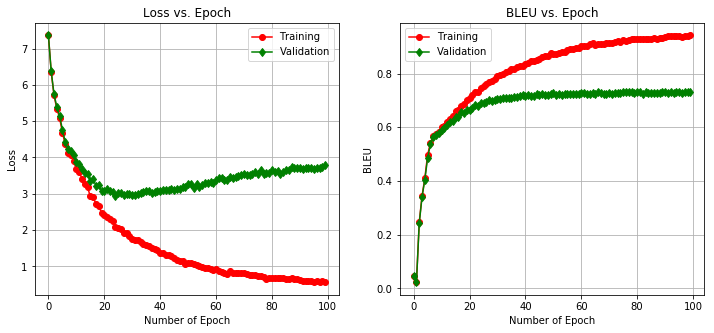

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(range(n_epochs), LOSS_train, 'ro-', label='Training')
plt.plot(range(n_epochs), LOSS_val, 'gd-', label='Validation')
plt.title('Loss vs. Epoch')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(range(n_epochs), BLEU_train, 'ro-', label='Training')
plt.plot(range(n_epochs), BLEU_val, 'gd-', label='Validation')
plt.title('BLEU vs. Epoch')
plt.xlabel('Number of Epoch')
plt.ylabel('BLEU')
plt.grid()
plt.legend()

### Begin evaluating

In [12]:
#####################################################################################
# test process:
# evaluate on test set using the best models saved
#####################################################################################
encoder.load_state_dict(torch.load('./model_encoder.pt'))
decoder.load_state_dict(torch.load('./model_decoder.pt'))
output_sentences, loss_test, bleu_test = evaluate(
    input_lang, output_lang, pairs_test, encoder, decoder, MAX_SENTENCE_LENGTH) 

print("Test loss = {}".format(sum(loss_test)/len(loss_test)))
print("Test BLEU = {:.3f}".format(sum(bleu_test)/len(bleu_test)))

loss_sort = np.argsort(loss_test)
for example in range(5):
    sentence_german = pairs_test[loss_sort[example],0]
    sentence_english = pairs_test[loss_sort[example],1]
    sentence_translated = output_sentences[loss_sort[example]]
    print('Example #{}'.format(example+1))
    print('Input German = {}'.format(sentence_german))
    print('Reference English = {}'.format(sentence_english))
    print('Translated English = {}'.format(sentence_translated))

Test loss = 2.99136037543
Test BLEU = 0.685
Example #1
Input German = weit du wo er wohnt
Reference English = do you know where he lives
Translated English = do you know where he lives
Example #2
Input German = wisst ihr wo er wohnt
Reference English = do you know where he lives
Translated English = do you know where he lives
Example #3
Input German = wo hast du tom gefunden
Reference English = where did you find tom
Translated English = where did you find tom
Example #4
Input German = bist du wach
Reference English = are you awake
Translated English = are you awake
Example #5
Input German = ich brauche ein neues auto
Reference English = i need a new car
Translated English = i need a new car
